In [1]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.mode.chained_assignment = None

# Applied Machine Learning
In this assignment we will explore a dataset about soccer players and referees, focusing predictions and clustering essentially on the players' skin color.

## Preprocessing

Let's have a look at the data:

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.ix[:5,:14]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0


In [3]:
data.ix[:5,14:]

,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


### NaN values

In [4]:
data.isnull().sum()

playerShort          0
player               0
club                 0
leagueCountry        0
birthday             0
height             263
weight            2243
position         17726
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          21407
rater1           21407
rater2           21407
refNum               0
refCountry           0
Alpha_3              1
meanIAT            163
nIAT               163
seIAT              163
meanExp            163
nExp               163
seExp              163
dtype: int64

In [5]:
filtered = data.dropna()

In [6]:
len(filtered)/len(data)

0.790649738406333

If we would decide to simply discard all the NaN values, we would keep only 21% of the DataSet. We are mainly interested in the skin color of each player so we will have a closer look at the `rater1` and `rater2` skin rating columns.

### Skin Color

In [7]:
len(data[data.rater1.isnull() & (data.rater2.isnull())])/len(data)

0.14659517352836443

15% of the dataset will be discarded as it doesn't give any information about the skin color.

In [8]:
skin_data = data.dropna(how='all', subset=['rater1','rater2'])

We will also drop the cell with missing IAT or Exp score as there are only 152

In [9]:
skin_data = skin_data.dropna(how='all', subset=['meanIAT', 'nIAT'])

In [10]:
len(skin_data[skin_data.rater1.isnull() | (skin_data.rater2.isnull())])

0

We can observe that there were always values for both `rater1` and `rater2` or not any values. Let's have a look at the data for which the raters gave a different skin color.

In [11]:
skin_data_differ = skin_data[skin_data.rater1 != skin_data.rater2]

In [12]:
len(skin_data_differ)/len(skin_data)

0.23189896198219623

For 23% of the player the two raters gave a different value. Let's see if they gave skin colors that are almost the same or opposite skin colors:

In [13]:
skin_data['skin_difference'] = skin_data.apply(lambda x: abs(x['rater1'] - x['rater2']), axis=1)

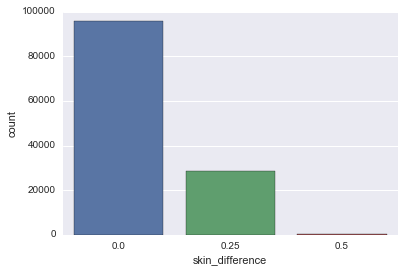

In [14]:
palette = sns.color_palette()
sns.countplot(x="skin_difference", data=skin_data);

If the two raters differ, it is only by one on the 5-point scale or by 2. We decide to keep the average value of the two raters on a 0 to 8 scale. (so that the average keep all the information)

In [15]:
skin_data['skin'] = skin_data.apply(lambda x: (x['rater1']+x['rater2'])/2*4, axis=1)

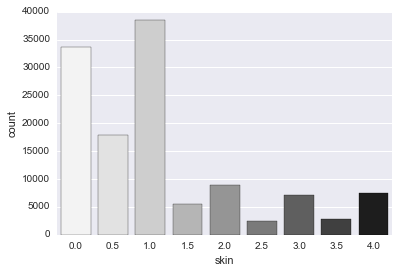

In [16]:
sns.countplot(x="skin", data=skin_data, palette=sns.color_palette("Greys", 9));

We can observe that the raters are probably not that accurate as the data is skewed.

### Age
There are not any missing birthday value. We will have a look at the age distribution.

In [17]:
# The birthday string is converted into a datetime type
import datetime
skin_data['birthday'] = skin_data.apply(lambda x: datetime.datetime.strptime(x['birthday'], "%d.%m.%Y"), axis=1)

In [18]:
skin_data['birthday'].head()

0   1983-08-31
1   1982-01-08
5   1979-11-08
6   1985-11-10
7   1986-04-04
Name: birthday, dtype: datetime64[ns]

In [19]:
import datetime as DT
now = pd.Timestamp(DT.datetime.now())
# We will plot the age in year of the players from their birthday
age = skin_data[['birthday']]
age['age'] = age.apply(lambda x: int((now - x['birthday']).days/365.25) , axis=1)

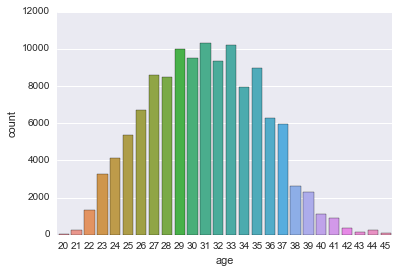

In [20]:
p = sns.countplot(x="age", data=age)

Everything seems fine for the date values.

### League Country

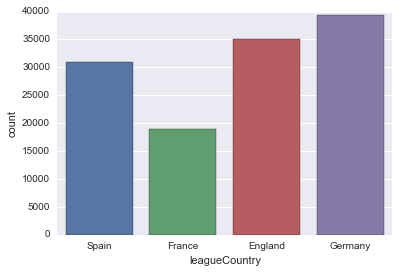

In [21]:
sns.countplot(x="leagueCountry", data=skin_data);

### Height

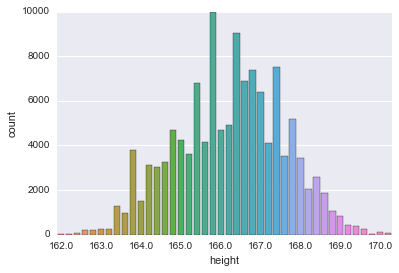

In [22]:
import matplotlib.ticker as ticker
heights = skin_data[['height']]
h = sns.countplot(x="height", data=heights)
h.xaxis.set_major_locator(ticker.MultipleLocator(5))

There is no outliers and the distribution looks normal.

### Weight

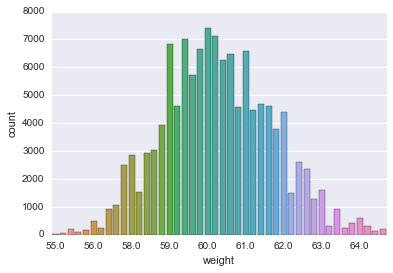

In [23]:
w = sns.countplot(x="weight", data=skin_data)
w.xaxis.set_major_locator(ticker.MultipleLocator(5))

### Position 

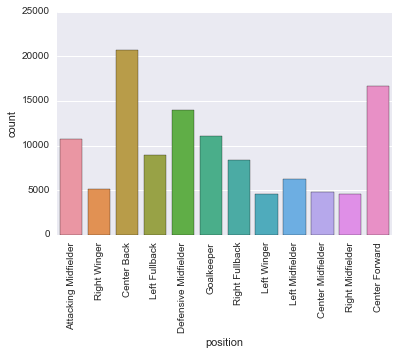

In [24]:
pos = sns.countplot(x="position", data=skin_data);
plt.setp(pos.get_xticklabels(), rotation=90);

In [25]:
missing_values = skin_data['position'].isnull().value_counts()

In [26]:
missing_values[1]/missing_values[0]

0.072870515627424276

7% of the positions are missing. We will replace them by the most by a category `Missing Position`.

### Referees

In [27]:
print('There are ' + str(len(skin_data['refNum'].value_counts())) + ' different referees.')

There are 2967 different referees.


In [28]:
print('Which come from ' + str(len(skin_data['refCountry'].value_counts())) + ' different countries...')

Which come from 155 different countries...


### Standardization, Categorical Features Encoding and Replacing Missing Values

We transform each feature into a representation that is more suitable for the machine learning methods. Each feature will be **standardized** if it is a float number (remove mean value, scale dividing by standard deviation) using the `StandardScaler()` function from `sklearn`. If there are missing values, they will be replaced by the mean, which is 0 after applying the StandardScaler. The categorical features will be **encoded** using the `LabelEncoder()` function which converts categorical variable into numerical values. The learning models consider continuous values and don't handle categorical features, but we hope RandomForest will be robust again those values. The missing categorical variables are replaced by `Missing Category`. We discard the name of the player, as well as the photoID and the birthday as it is a one to one relationship with the skin color.

In [101]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, Imputer 
from sklearn.feature_extraction import DictVectorizer

# Replacing missing values for categorical data:
skin_data['position'] = skin_data['position'].fillna('Missing Position')
# For the Alpha_3 there is only one missing value so we will drop it
skin_data = skin_data.dropna(subset=['Alpha_3'])

# Features to be standardized
stand = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'redCards', 'yellowReds', 'skin', 'skin_difference', 'rater1', 'rater2']
# Categorical features to be encoded
cat = ['club', 'leagueCountry', 'position', 'Alpha_3']

standardized = skin_data.copy()
standardized['skin_nonorm'] = standardized['skin']
# Encode categories
for c in cat:
    standardized[c] = LabelEncoder().fit_transform(standardized[c])

# The first function fills the missing values and the second one will apply the standardization 
for s in stand:
    standardized[s] = Imputer(strategy='mean', axis=1).fit_transform(standardized[s])[0]
    standardized[s] = StandardScaler().fit_transform(standardized[s])
    
    
    
# Discard names of players and photoID
skin_data_dropped = standardized.drop(labels=['playerShort','player', 'photoID','birthday'], axis=1)

In [102]:
skin_data_dropped.head()

,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,...,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_difference,skin,skin_nonorm
0,70,3,-0.753585,-0.609844,0,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,59,0.326391,712.0,0.000564,0.396000,750.0,0.002696,1.800031,0.317661,1.5
1,51,1,-0.459621,0.785575,12,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,153,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,-0.547478,1.617787,3.0
5,34,0,-0.018675,-0.749386,1,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,87,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.800031,-0.549090,0.5
6,48,0,0.716234,0.506492,6,-0.557169,-0.182707,-0.625217,-0.658021,-0.374371,...,87,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.800031,-0.549090,0.5
7,54,0,-0.312639,-1.168011,4,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,87,0.325185,127.0,0.003297,0.538462,130.0,0.013752,-0.547478,2.484538,4.0


# 1. Random Forest Skin Color Regressor

**We use Random Forest Regressor and Classifier because darkness of skin reflect a continuous value, we talked about it with Catasta on slack**

The most important parameters that can affect the accuracy of the random forest regressor are the number of trees in the forest `n_estimators`, the number of features to consider when looking for a best split `max_features`, the maximum depth of the tree `max_depth` and the minimum number of samples required to be at a leaf node `min_samples_leaf`. There are other parameters but we will have a closer look at those ones.

We seperate the data between the features used for prediction and the target features (skin). We need to drop the `rater1`, `rater2`, `skin` and `skin_difference` values as we want to predict the `skin`.

In [31]:
to_predict = ['rater1', 'rater2', 'skin', 'skin_difference']
data = skin_data_dropped.drop(labels=to_predict, axis=1)
features = data.columns
# Skin to predict
target = skin_data_dropped['skin'].values.ravel()

First, all the columns will be used to train the Random Forest Classifier.

### n_estimators
We will test the accuracy of the model for different number of trees. We use 5-folds cross validation to measure the accuracy of the predictive model, we use the mean of the accuracy over the 5 folds to tune the parameters.

In [32]:
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

In [33]:
number_trees = [5,10,20,50,100,200]
accuracy = []

for t in number_trees:
    tree = RandomForestRegressor(n_estimators=t)
    scores = cross_validation.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

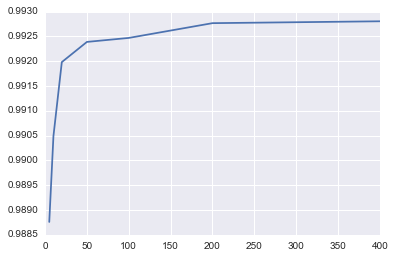

In [34]:
plt.plot(number_trees, accuracy);

Higher number of trees will avoid overfitting (because the model takes the maximum voting of predictions) and give more stable predictions but it makes the code run slower. We decide to keep 100 trees.

### max_features
As default, the number of features to consider when looking for the best split is equal to the square root of the number of features. We will test it with different values between 1 and the number of features.

In [35]:
max_features = range(1,len(features)+1,2)
accuracy = []

for m in max_features:
    tree = RandomForestRegressor(n_estimators=100, max_features=m)
    scores = cross_validation.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

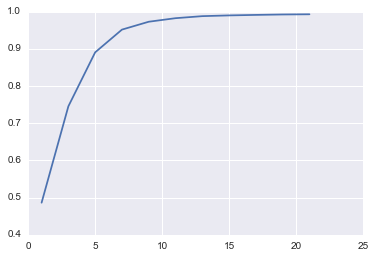

In [36]:
plt.plot(max_features, accuracy);

Increasing max_features improves the performance of the model (at each node now we have a higher number of options). However it increases the speed of algorithm. We choose to take `max_features`=5.



### max_depth
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure.

In [37]:
max_depths = [1,5,10,50]
accuracy = []

for d in max_depths:
    tree = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=d)
    scores = cross_validation.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

In [39]:
#We compute as well with the default value
tree = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=None)
scores = cross_validation.cross_val_score(tree, data, target, cv=5)
accuracy.append(scores.mean())

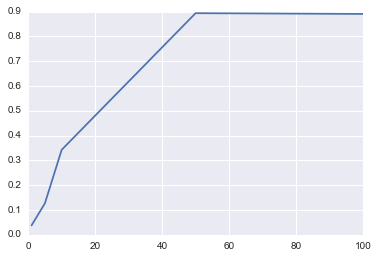

In [40]:
max_depths.append(100) # it will simple represent the default value
plt.plot(max_depths, accuracy);

In our case, there is no overfitting problem with a tree having pure nodes. We will keep the default value.

### min_samples_leaf
The minimum number of samples required to be at a leaf node (we will give it in percentage)

In [41]:
min_samples = [0.01,0.02,0.05,0.1]
accuracy = []

for s in min_samples:
    tree = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=s)
    scores = cross_validation.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

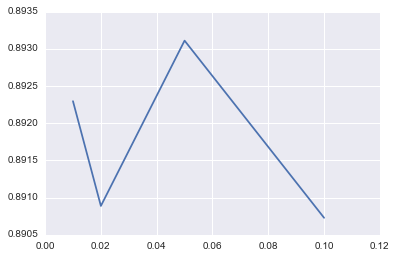

In [42]:
plt.plot(min_samples, accuracy);

If less than 0.02% are in a leaf the model is overfitting and if more than 0.02% are in a leaf node it is underfitting.

### feature\_importances\_
Now we will have a look at the feature sorted by their score in the tree with the tuned parameter we found.

In [44]:
tree = RandomForestRegressor(n_estimators=100, max_features=5).fit(data, target)

In [45]:
sorted(zip(map(lambda x: round(x, 4), tree.feature_importances_), features), reverse=True)

[(0.20039999999999999, 'weight'),
 (0.19400000000000001, 'club'),
 (0.18959999999999999, 'height'),
 (0.1484, 'position'),
 (0.057599999999999998, 'leagueCountry'),
 (0.031, 'refNum'),
 (0.0189, 'meanExp'),
 (0.016899999999999998, 'games'),
 (0.016500000000000001, 'meanIAT'),
 (0.0147, 'victories'),
 (0.0124, 'Alpha_3'),
 (0.011900000000000001, 'refCountry'),
 (0.0118, 'goals'),
 (0.011599999999999999, 'defeats'),
 (0.0115, 'nIAT'),
 (0.0109, 'seIAT'),
 (0.0106, 'seExp'),
 (0.0104, 'nExp'),
 (0.0099000000000000008, 'ties'),
 (0.0091999999999999998, 'yellowCards'),
 (0.0011000000000000001, 'redCards'),
 (0.00089999999999999998, 'yellowReds')]

The `weight`, `club`, `height`, `position` and `leagueCountry` features are the ones adding the more information about the skin color. 

We will try to train the tree only with those features to see if their importance order changes.

In [47]:
reduced_features = ['club','height','weight','position', 'leagueCountry']
tree = RandomForestRegressor(n_estimators=100, max_features=5).fit(data[reduced_features], target)

In [48]:
sorted(zip(map(lambda x: round(x, 4), tree.feature_importances_), features), reverse=True)

[(0.27610000000000001, 'height'),
 (0.2442, 'leagueCountry'),
 (0.21870000000000001, 'club'),
 (0.19500000000000001, 'weight'),
 (0.066100000000000006, 'position')]

It is interesting to see that the order of the features changes, the `leagueCountry` is now the feature adding the most information about the skin color even if it was in the last position in the previous tree classifier. 

# 2. Clustering

We group the referee informations by player and only keep the columns that are relevant, the order is useful because it will be the one used when iteratively removing features

In [134]:
filtered_col = ['playerShort', 'skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals',
                'yellowCards', 'yellowReds', 'redCards', 'skin_nonorm']
filtered = standardized[filtered_col]
grouped = filtered.groupby('playerShort').mean()

In [135]:
grouped.isnull().sum()

skin               0
skin_difference    0
meanIAT            0
meanExp            0
weight             0
height             0
games              0
victories          0
ties               0
defeats            0
goals              0
yellowCards        0
yellowReds         0
redCards           0
skin_nonorm        0
dtype: int64

We see that there is not much null values, we simply drop them.

In [136]:
grouped = grouped.dropna()
grouped.head()

,skin,skin_difference,meanIAT,meanExp,weight,height,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skin_nonorm
playerShort,,,,,,,,,,,,,,,
aaron-hughes,-0.549090,1.800031,0.346459,0.494575,-0.749386,-0.018675,0.263530,0.076741,0.317084,0.306836,-0.316979,-0.346780,-0.108671,-0.112016,0.5
aaron-hunt,-0.549090,1.800031,0.348818,0.449220,-0.470302,0.128306,0.111152,0.042866,0.019149,0.207666,0.288572,0.030080,-0.108671,-0.023386,0.5
aaron-lennon,-0.115715,-0.547478,0.345893,0.491482,-1.865721,-2.517367,0.302460,0.338473,0.214040,0.141837,-0.049463,-0.353528,-0.108671,-0.112016,1.0
aaron-ramsey,-0.982466,-0.547478,0.346821,0.514693,-0.051676,-0.606603,-0.138411,0.052472,-0.272310,-0.198705,0.022593,-0.123403,-0.108671,-0.027647,0.0
abdelhamid-el-kaoutari,-0.115715,-0.547478,0.331600,0.335587,-0.470302,-0.312639,0.099263,-0.125225,0.319503,0.158379,-0.345761,-0.222989,0.864236,0.362271,1.0


In [137]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

We now compute the silhouette score and remove iteratively features. We keep track of 2 score, the one by silhouette score of the clusterisation by k-mean and its own labels, and the one corresponding to the proportion of partitionned data along the skin value (split at skin value = 2.0)

In [138]:
skin_labels = (grouped['skin_nonorm'] < 2.0).astype(int) 
skin_labels.head()

playerShort
aaron-hughes              1
aaron-hunt                1
aaron-lennon              1
aaron-ramsey              1
abdelhamid-el-kaoutari    1
Name: skin_nonorm, dtype: int64

In [150]:


def cluster(X):
    kmeans_model = KMeans(n_clusters=2, random_state=1).fit(X)
    labels = kmeans_model.labels_
    
    silhouette_unsupervised = silhouette_score(X, labels)
    np.mean(silhouette_unsupervised)
    eq = skin_labels == labels
    mean = np.mean(eq)
    skin_partition = max(mean, 1-mean)
    
    return  silhouette_unsupervised, skin_partition

We do two iterative feature removing. One with the skin features included and one without. The aim is to find if we can cluster the skin information without having it as a feature.

In [168]:
silhouettes_unsupervised = []
skin_partitions = []
feature_number = []

#We always drop skin_nonorm. It was only used for labeling before standardization
for i in range(len(filtered_col)-1, 5, -1):
    columns = filtered_col[5:i]
    silhouette_unsupervised, skin_partitionning = cluster(grouped[columns])
    
    silhouettes_unsupervised.append(silhouette_unsupervised)
    skin_partitions.append(skin_partitionning )
    print(silhouette_unsupervised, skin_partitionning, columns)
    feature_number.append(i-1)

0.347652515645 0.509779179811 ['weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
0.350943096869 0.509779179811 ['weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds']
0.354696417852 0.509779179811 ['weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards']
0.371015245425 0.509148264984 ['weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals']
0.394023015198 0.511041009464 ['weight', 'height', 'games', 'victories', 'ties', 'defeats']
0.409970101111 0.51167192429 ['weight', 'height', 'games', 'victories', 'ties']
0.425129269071 0.51167192429 ['weight', 'height', 'games', 'victories']
0.443469374991 0.51167192429 ['weight', 'height', 'games']
0.475079984684 0.51167192429 ['weight', 'height']
0.55352283463 0.502208201893 ['weight']


In [169]:
print(silhouettes_unsupervised)
print(skin_partitions)

[0.3476525156453048, 0.35094309686938324, 0.35469641785175876, 0.37101524542498959, 0.39402301519815797, 0.40997010111071602, 0.42512926907133169, 0.44346937499130695, 0.47507998468394014, 0.55352283462984642]
[0.50977917981072551, 0.50977917981072551, 0.50977917981072551, 0.50914826498422716, 0.51104100946372233, 0.51167192429022079, 0.51167192429022079, 0.51167192429022079, 0.51167192429022079, 0.50220820189274451]


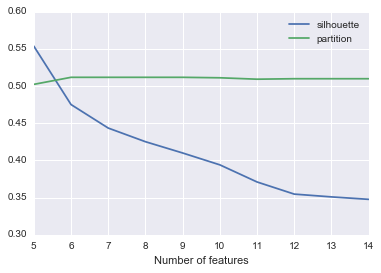

In [170]:
plt.plot(feature_number, silhouettes_unsupervised, label='silhouette');
plt.plot(feature_number, skin_partitions, label='partition');
plt.xlabel('Number of features');
plt.legend();

We can see that the silhouette goes up as the number of features go down (easier to cluster) but it doesn't improve the paritition along skin color. Clusterisation doesn't reveal any correlation with Skin color. 


Let's now try by adding the skin feature to check if there is now a distinction

In [171]:
silhouettes_unsupervised = []
skin_partitions = []
feature_number = []

for i in range(len(filtered_col)-1, 1, -1):
    columns = filtered_col[1:i]
    silhouette_unsupervised, skin_partitionning = cluster(grouped[columns])
    
    silhouettes_unsupervised.append(silhouette_unsupervised)
    skin_partitions.append(skin_partitionning )
    print(silhouette_unsupervised, skin_partitionning, columns)
    feature_number.append(i-1)

0.220936710261 0.558359621451 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
0.222183058978 0.556466876972 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds']
0.223634526471 0.556466876972 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards']
0.229909739671 0.557728706625 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties', 'defeats', 'goals']
0.238405175875 0.554574132492 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties', 'defeats']
0.244138560099 0.553943217666 ['skin', 'skin_difference', 'meanIAT', 'meanExp', 'weight', 'height', 'games', 'victories', 'ties']
0.249305642858 0.552681388013 ['skin', 'skin

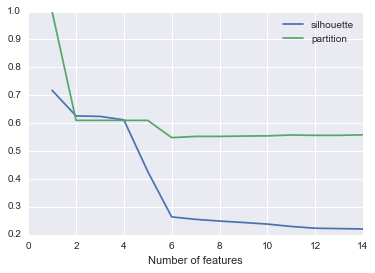

In [172]:
plt.plot(feature_number, silhouettes_unsupervised, label='silhouette');
plt.plot(feature_number, skin_partitions, label='partition');
plt.xlabel('Number of features');
plt.legend();

In [ ]:
We can that the silhouette go down and of that the partitionning along skin improve with skin fea but more surprisingly with skin_difference too.